In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def i_constant(time, i=5):
    """I(t) = 5"""
    return i

In [3]:
def i_step(time, i=5, d1=(20, 30), d2=(40, 50), d3=(60, 80)):
    """I(t) = 5"""
    s1, e1 = d1
    s2, e2 = d2
    s3, e3 = d3
    if s1 < time < e1 or s2 < time < e2 or s3 < time < e3:
        return i
    return 0

In [4]:
def i_sine(time, c=15):
    """I(t) = 15.(sin(t) + 0.9)"""
    return c * (0.9 + np.sin(time))

In [5]:
def i_interval(time, i=5, duration=(20, 80)):
    """I(t) = 5"""
    start, end = duration
    if start < time < end:
        return i
    return 0

In [6]:
def i_linear(time, c=2):
    """I(t) = 2.t"""
    return c * time

In [7]:
class AELIF:
    def __init__(self, time=100, dt=0.125, i_function=i_interval, u_rest=0, r=1, c=10, threshold=5, delta_t=2,
                theta_rh=2, a=2, b=2, w_constant=5):
        self.time = time
        self.dt = dt
        self.i_function = i_function
        self.u_rest = u_rest
        self.r = r
        self.c = c
        self.threshold = threshold
        self.delta_t = delta_t
        self.theta_rh = theta_rh
        self.a = a
        self.b = b
        self.w_constant = w_constant
        self.u = []
        self.init_u()
        
    def spike_time(self, i):
        timer = np.arange(0, self.time + self.dt, self.dt)
        time_const = self.r * self.c
        u = [self.u_rest for i in range(len(timer))]
        w = [0 for _ in range(len(timer))]
        sigma_delta_function = 0
        i_input = [i_constant(j, i=i) for j in timer]
        spike_t = self.time
        current_spike_time = 0
        
        for j in range(len(timer)):
            u[j] = u[j - 1] + ((self.r * i_input[j] - (u[j - 1] - self.u_rest) + self.delta_t * np.exp(
                (u[j - 1] - self.theta_rh) / self.delta_t) - self.r * w[j - 1])) * self.dt / time_const
            if u[j] >= self.threshold:
                sigma_delta_function = 1
                u[j] = self.u_rest
                prev_spike_time = current_spike_time
                current_spike_time = timer[j]
                spike_t = min(spike_t, current_spike_time - prev_spike_time)
                
            w[j] = w[j - 1] + (self.a * (u[j - 1] - self.u_rest)
                               - w[j - 1] + self.b * self.w_constant *
                               sigma_delta_function) * self.dt / self.w_constant
            sigma_delta_function = 0
                
        return spike_t

    def init_u(self):
        timer = np.arange(0, self.time + self.dt, self.dt)
        time_const = self.r * self.c
        u = [self.u_rest for i in range(len(timer))]
        w = [0 for _ in range(len(timer))]
        i_input = [self.i_function(j) for j in timer]
        sigma_delta_function = 0
        
        for j in range(len(timer)):
            u[j] = u[j - 1] + ((self.r * i_input[j] - (u[j - 1] - self.u_rest) + self.delta_t * np.exp(
                (u[j - 1] - self.theta_rh) / self.delta_t) - self.r * w[j - 1])) * self.dt / time_const
            if u[j] >= self.threshold:
                sigma_delta_function = 1
                u[j] = self.u_rest
            w[j] = w[j - 1] + (self.a * (u[j - 1] - self.u_rest)
                               - w[j - 1] + self.b * self.w_constant *
                               sigma_delta_function) * self.dt / self.w_constant
            sigma_delta_function = 0
                
        self.u = u

    def plot(self, u_t=False, i_t=False, f_i=False):
        fig = plt.figure(num=None, figsize=(20, 10))
        fig.suptitle("R: " + str(self.r) +
                     "    C: " + str(self.c) +
                     "    I: " + (str(self.i_function.__doc__).strip()) +
                     "    THRESHOLD: " + str(self.threshold) + 
                     "    THETA_RH: " + str(self.theta_rh) + 
                     "    DELTA_T: " + str(self.delta_t) + 
                     "    a: " + str(self.a) + 
                     "    b: " + str(self.b) +
                     "    tw: " + str(self.w_constant), fontsize=14, fontweight='bold')
        
        timer = np.arange(0, self.time + self.dt, self.dt)
        i_input = [self.i_function(j) for j in timer]
        
        if u_t:
            plt.subplot(221)
            plt.plot(timer, self.u)
            plt.ylabel('Membrane Potential')
            plt.xlabel('Time')
            plt.title('Adaptive Exponential Leaky Integrate-and-Fire')
                
        if i_t:
            plt.subplot(221)
            plt.plot(timer, i_input, color='orange')
            plt.ylabel('Input Current')
            plt.xlabel('Time')
            plt.title('Input Current')
            
        if f_i:
            i_x = np.arange(0, max(i_input), self.dt)
            i_y = [0 for _ in range(len(i_x))]
            
            for j in range(len(i_x)):
                try:
                    i_y[j] = 1 / (self.spike_time(i_x[j]))
                except:
                    i_y[j] = 0
            plt.subplot(221)
            plt.plot(i_x, i_y, color = 'g')
            plt.ylabel('Frequency')
            plt.xlabel('Input Current')
            plt.title('F - I')

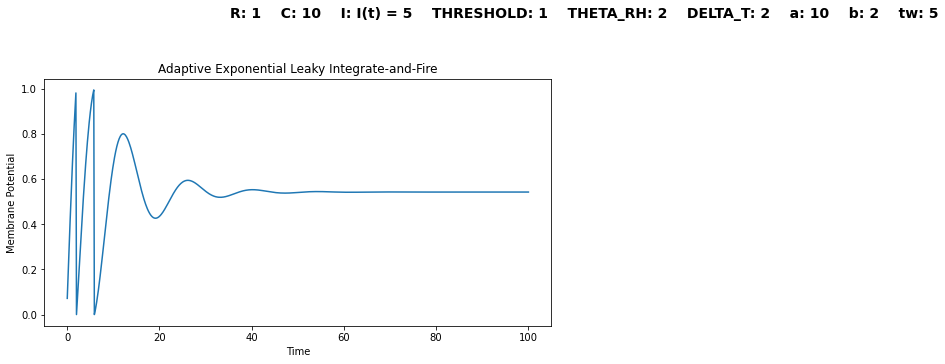

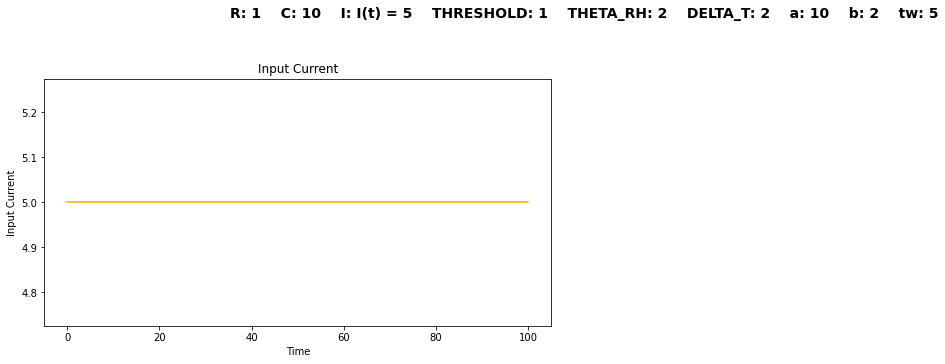

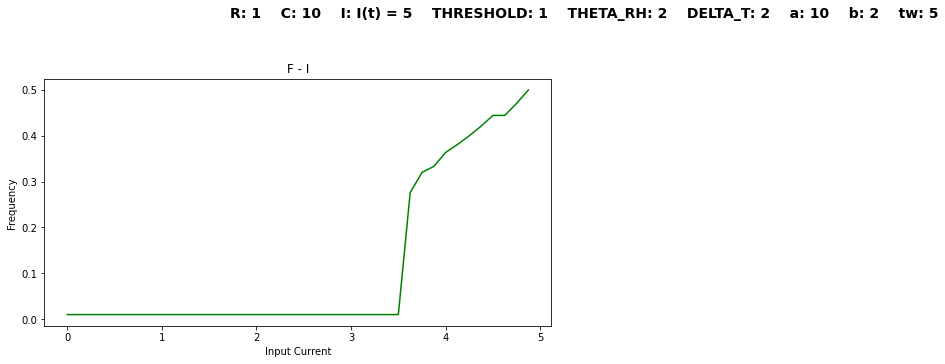

In [8]:
aelif = AELIF(i_function=i_constant, time=100, a=10, threshold=1)
aelif.plot(u_t=True)
aelif.plot(i_t=True)
aelif.plot(f_i=True)

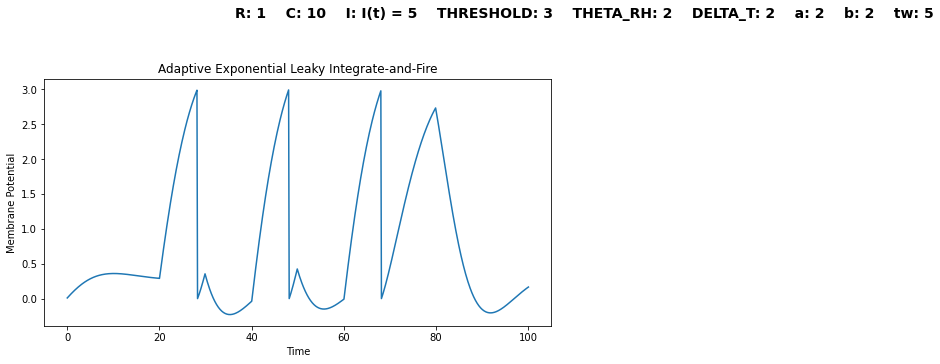

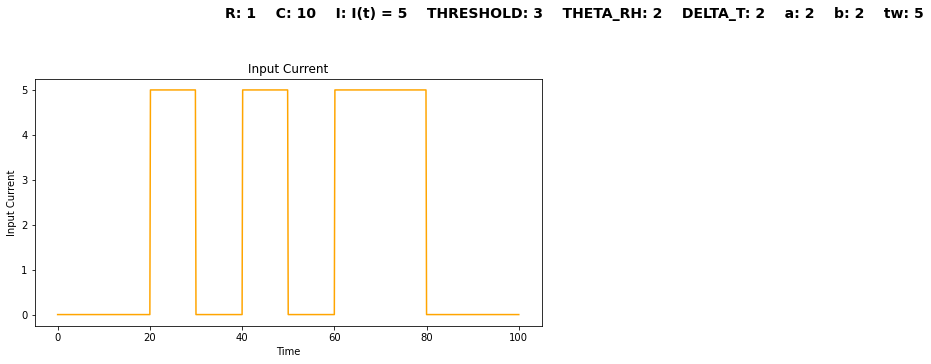

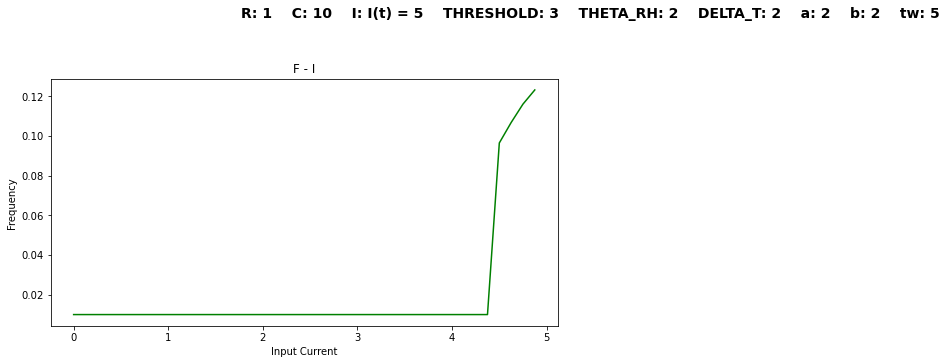

In [9]:
aelif = AELIF(i_function=i_step, threshold=3)
aelif.plot(u_t=True)
aelif.plot(i_t=True)
aelif.plot(f_i=True)

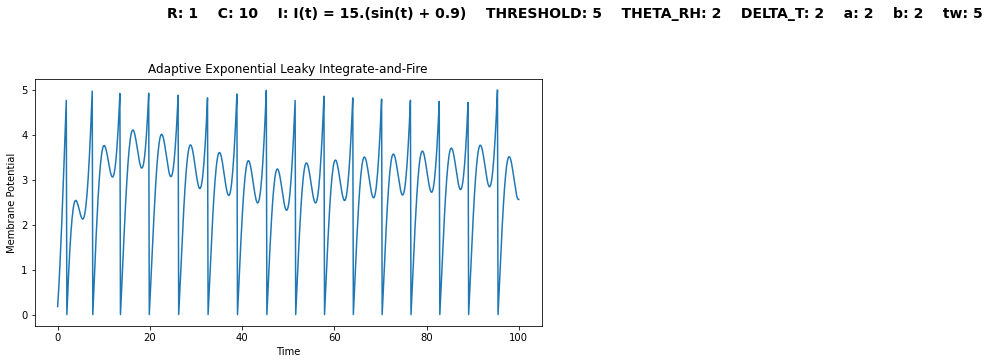

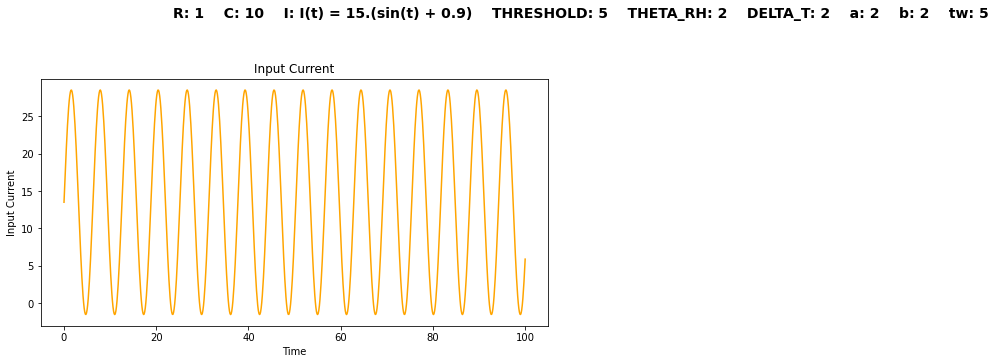

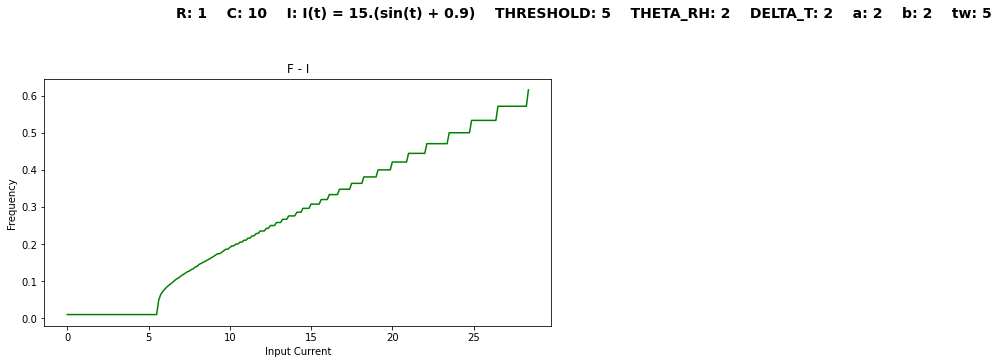

In [10]:
aelif = AELIF(i_function=i_sine)
aelif.plot(u_t=True)
aelif.plot(i_t=True)
aelif.plot(f_i=True)

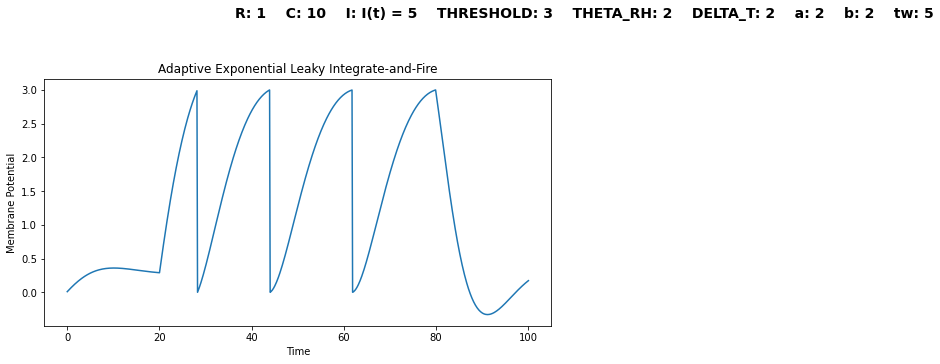

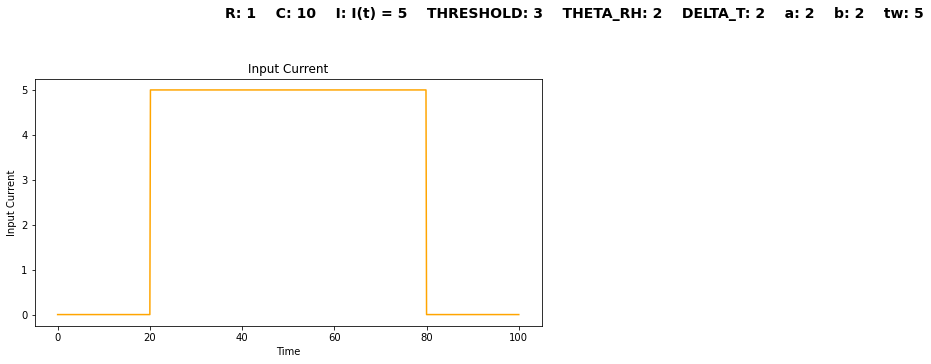

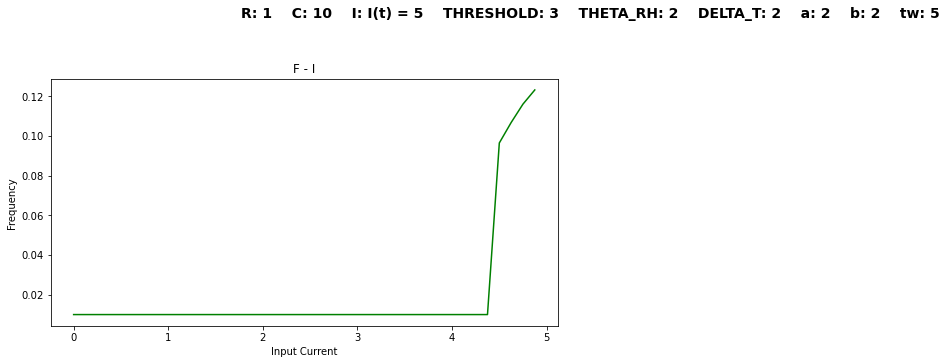

In [11]:
aelif = AELIF(threshold=3, i_function=i_interval)
aelif.plot(u_t=True)
aelif.plot(i_t=True)
aelif.plot(f_i=True)

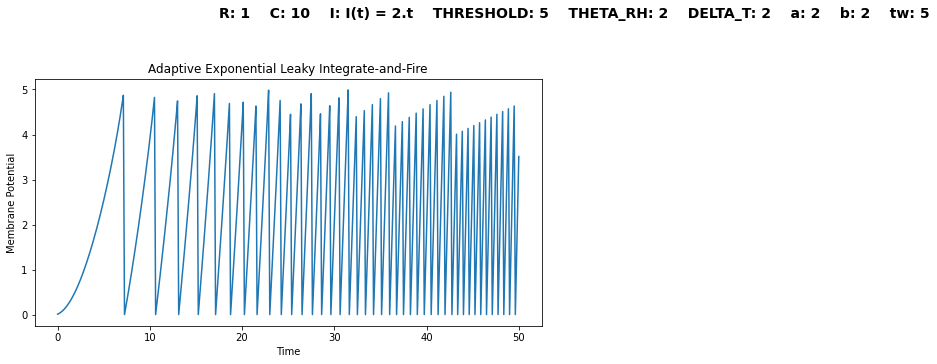

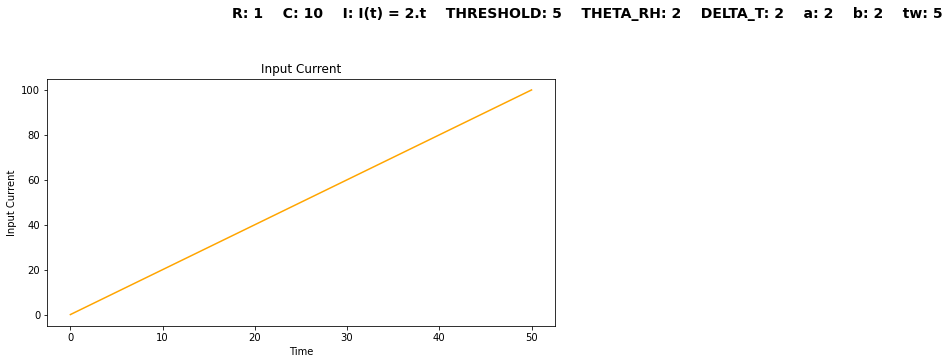

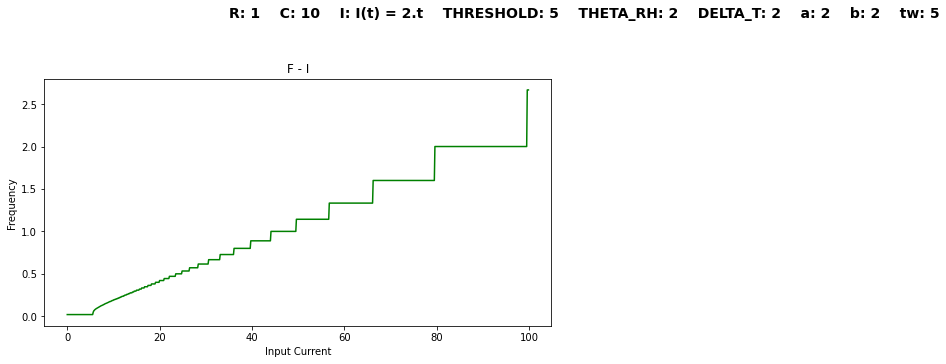

In [12]:
aelif = AELIF(threshold=5, i_function=i_linear, time=50)
aelif.plot(u_t=True)
aelif.plot(i_t=True)
aelif.plot(f_i=True)

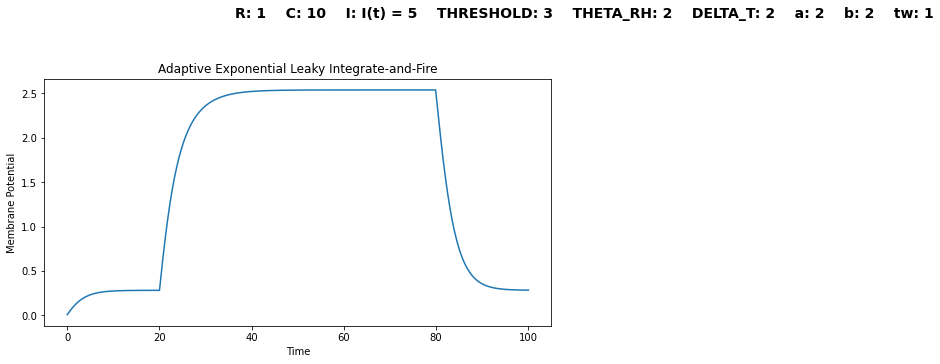

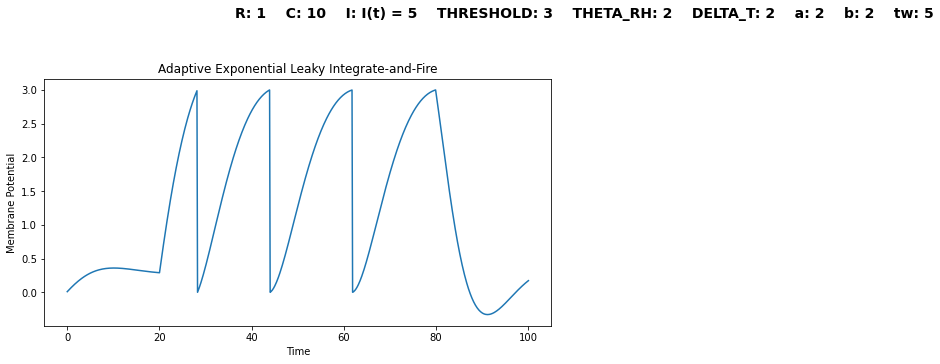

In [13]:
aelif = AELIF(threshold=3, w_constant=1)
aelif.plot(u_t=True)

aelif = AELIF(threshold=3, w_constant=5)
aelif.plot(u_t=True)

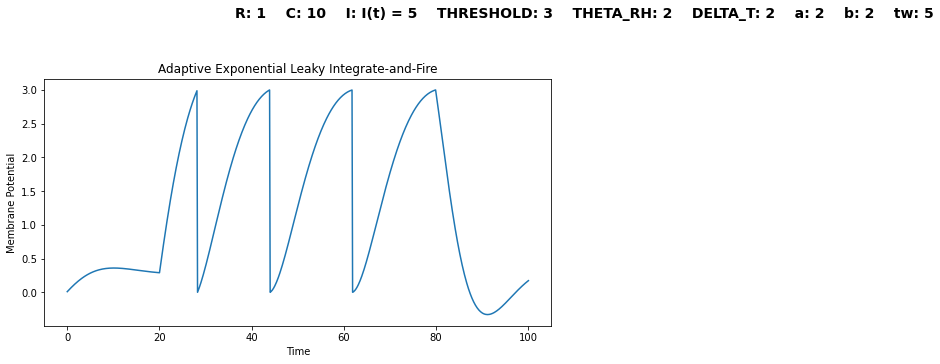

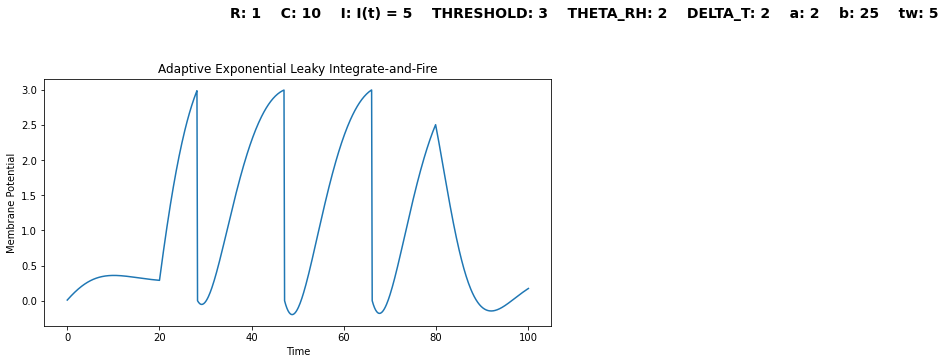

In [16]:
aelif = AELIF(threshold=3, b=2)
aelif.plot(u_t=True)

aelif = AELIF(threshold=3, b=25)
aelif.plot(u_t=True)

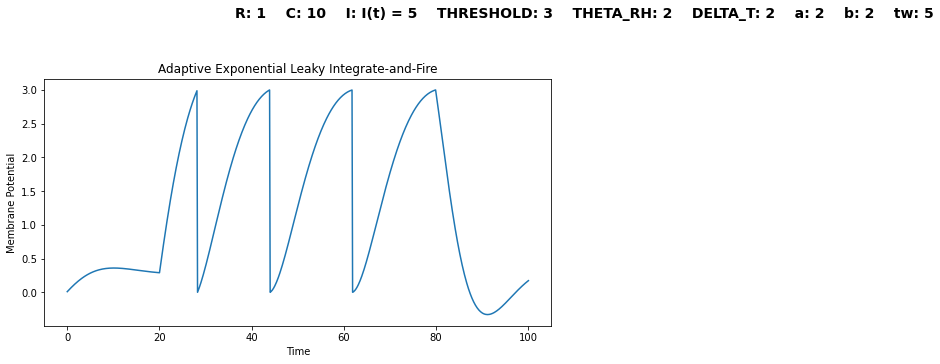

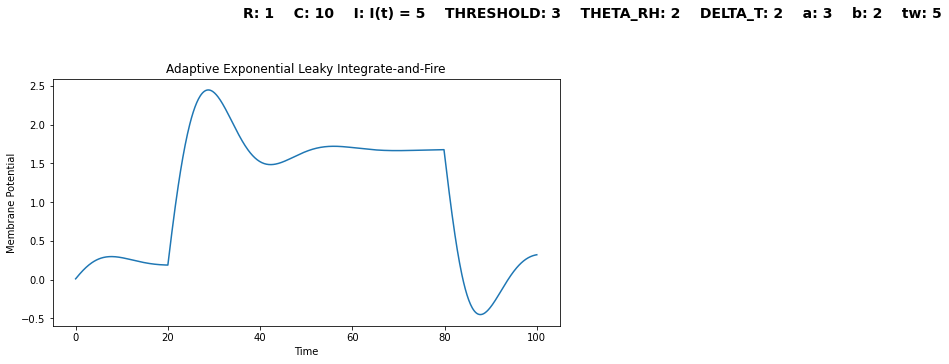

In [17]:
aelif = AELIF(threshold=3, a=2)
aelif.plot(u_t=True)

aelif = AELIF(threshold=3, a=3)
aelif.plot(u_t=True)